In [ ]:
import gym
import torch
import torch.nn as nn
from torch.distributions import Categorical
import matplotlib.pyplot as plt
!pip install gym[classic_control]
!pip install gym[box2d] #for lunarlander
!apt update
!apt install xvfb
!pip install pyvirtualdisplay
!pip install gym-notebook-wrapper
import gnwrapper
!nvidia-smi
print(torch.cuda.is_available())

In [ ]:
class Agent(nn.Module):
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.P = PolicyNetwork(input_dim, output_dim, width)
        self.P.to(device)
        self.P.train()  
        self.P_optimizer = torch.optim.Adam(self.P.parameters(), lr=0.0003)
        self.V = ValueNetwork(input_dim, output_dim, width)
        self.V.to(device)        
        self.V.train()
        self.V_optimizer = torch.optim.Adam(self.V.parameters(), lr=0.0003)  
        self.trajectory = []      
        self.env = gym.make(game_name)        

    def self_play_old_P(self, max_timestep=1000000):
        game_score = 0
        state = self.env.reset() 
        for _ in range(max_timestep):               
            old_state = state
            output = self.P(torch.from_numpy(state).float().to(device)) 
            inferenced_v = self.V(torch.from_numpy(state).float().to(device))
            prob_distribution = Categorical(output)
            action = prob_distribution.sample() 
            state, r, done, _ = self.env.step(action.item()) 
            with torch.no_grad():
                inferenced_v_from_next_s = self.V(torch.from_numpy(state).float().to(device))
            if done==True:
                inferenced_v_from_next_s = 0
            self.trajectory.append((output, r, inferenced_v, inferenced_v_from_next_s, old_state ,action))
            game_score += r 
            if done:
                break
        return game_score

    def update_weights_PPO(self):
        for i in range(5): #epoch 
            ## without minibatch loop now ##
            A = 0 #GAE
            lam = 0.9  
            eps = 0.1      
            self.V_optimizer.zero_grad()
            self.P_optimizer.zero_grad()
            for old_output, r, v, v_next, old_s, old_a in self.trajectory[::-1]: 
                with torch.no_grad():           
                    delta = r + 0.99* v_next - v
                    A += (0.99 * lam) * delta  
                    V_target = A + v   

                v = self.V(torch.from_numpy(old_s).float().to(device))                
                V_loss = (V_target.item() - v)**2         
                V_loss.backward()          
            
                output = self.P(torch.from_numpy(old_s).float().to(device))
                upper = output.gather(0,old_a)
                lower = old_output.gather(0, old_a)                            
                probability_ratio = upper / lower.item() 
                
                L_clip = torch.min(
                    probability_ratio * A.item(),
                    torch.clip(probability_ratio, 1-eps, 1+eps) * A.item()
                )
                P_loss = -1 * L_clip 
                P_loss.backward()             
            self.V_optimizer.step()   
            self.P_optimizer.step()             
        self.trajectory.clear() 
        return 
   
class PolicyNetwork(nn.Module):  
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.layer3 = torch.nn.Linear(width, output_dim) 

    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer3(x)
        x = torch.nn.functional.softmax(x, dim=0)
        return x

class ValueNetwork(nn.Module): 
    def __init__(self, input_dim, output_dim, width):
        super().__init__()
        self.layer1 = torch.nn.Linear(input_dim, width)
        self.layer2 = torch.nn.Linear(width, width) 
        self.layer3 = torch.nn.Linear(width, 1) 

    def forward(self, x):
        x = self.layer1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer2(x)
        x = torch.nn.functional.relu(x)
        x = self.layer3(x)
        return x

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
score_arr = []
game_name = 'CartPole-v1' #'LunarLander-v2'   
env = gym.make(game_name) 
agent = Agent(env.observation_space.shape[0], env.action_space.n, 128) 
print(agent)
env.close()

#Self play, weight update
episode_nums = 300
for i in range(episode_nums):    
    game_score = agent.self_play_old_P()
    agent.update_weights_PPO()    
    score_arr.append(game_score)  
    if i%50==0 : print('episode', i)    
torch.save(agent.state_dict(), 'weights.pt') 
agent.env.close()

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


Agent(
  (P): PolicyNetwork(
    (layer1): Linear(in_features=4, out_features=128, bias=True)
    (layer2): Linear(in_features=128, out_features=128, bias=True)
    (layer3): Linear(in_features=128, out_features=2, bias=True)
  )
  (V): ValueNetwork(
    (layer1): Linear(in_features=4, out_features=128, bias=True)
    (layer2): Linear(in_features=128, out_features=128, bias=True)
    (layer3): Linear(in_features=128, out_features=1, bias=True)
  )
)
episode 0
episode 50
episode 100
episode 150
episode 200
episode 250


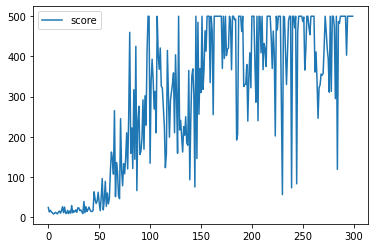

In [ ]:
#Score
plt.plot(score_arr, label ='score')
plt.legend(loc='upper left')

/usr/local/lib/python3.7/dist-packages/gym/core.py:50: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  "You are calling render method, "
/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


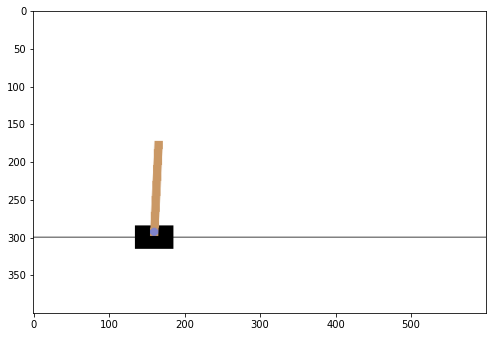

In [ ]:
#play video
agent.load_state_dict(torch.load("weights.pt"))
env = gnwrapper.LoopAnimation(gym.make(game_name)) 
state = env.reset()
for _ in range(200):
    with torch.no_grad():
        output = agent.P(torch.from_numpy(state).float().to(device))
        prob_distribution = Categorical(output) 
        action = prob_distribution.sample() 
    env.render()
    state, rew, done, _ = env.step(action.item())
    if done:
        state = env.reset()
env.display()